## Introduction
In this project, we'll attempt to predict the winner of the NBA MVP award based on data regarding previous contenders. The Most Valuable Player award is given out annually (at the end of each regular season) to the player deemed to have the largest impact on his team's success. The criteria for this award are not concrete, and (unfortunately for the purposes of prediction) there is no single formula used to determine the winner of the award.  
  
We will attempt to predict the `share` of points that each candidate in a given year receives using various regression models, and using this prediction, we will predict the player with the highest share of points to be the season's MVP.    
  
For our analysis, we'll limit our focus to the "modern era" of the NBA, starting in the year 1980.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#engineering
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#prediction
from xgboost import XGBRegressor

#validation
from sklearn.metrics import mean_squared_error

### Reading the Data  
  
I scraped the data that we'll be using from Basketball-Reference.com (code can be found in the Data Scraping and Cleaning notebook), and includes data on player and team stats for every player in the NBA from each year dating back to 1980, including each player's share of MVP votes.  

In [99]:
full = pd.read_csv('data/nba_player_stats.csv')

For convenience, we'll also make a DataFrame called `winners` containing only players who won the award.

In [3]:
winners = full[full['Rank']=='1']

### EDA and Feature engineering

While there is no concrete formula determining who the MVP will be, it's often said that the award is given to the best player on the best team. To investigate this, let's look at the `seed` column (note that a team's 'seed' is their team's ranking in their respective conference. In other words, the 1 seed is the team with the best record in the conference).

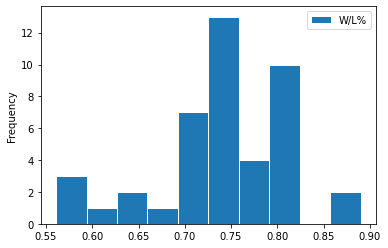

In [4]:
winners.plot(y = 'W/L%', kind = 'hist', ec = 'w')
plt.show()

It certainly seems that this adage has some weight to it. 30 of the winners (32 if we include those whose team was tied for the first seed) played for the team with the best record in their respective conference.  
But, being on the highest seeded team certainly doesn't guarantee winning the MVP award. As we can see, there are 143 players whose team was (at least tied for) the highest seed, yet only 32 of them won the award.

In [5]:
full[(full['seed'] == 1) |(full['seed'] == 1.5)]['Player'].count()

KeyError: 'seed'

And of course, a team's seed doesn't tell the whole story. There are often very small differences (perhaps only two or three games) separating the numer one seed from the number two or even number 3 seed. This makes it very difficult to say for certain which team was the "best" in a given season.  
To account for these differences, we'll consider a team's win/loss percentage (or the percentage of their games which they won), as this should minimize the impact of these potential differences.

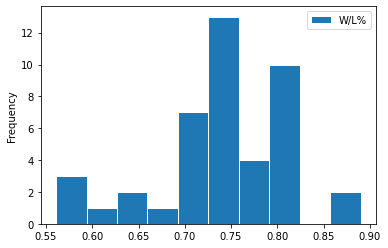

In [6]:
winners.plot(y = 'W/L%', kind = 'hist', ec = 'w')
plt.show()

So, now we have a better idea of which teams could be called "the best", but how can we determine who their best player was?  
To do this, we'll create interaction terms between a few individual statistics and the team's win/loss percentage. We expect these variables to be useful predictors as they should account for the event that a player had an exceptional individual season and won the award despite the fact that they don't play for an exceptionally good team (such as Russell Westbrook in 2016).

In [106]:
full['pts w/l'] = full['PTS'] * full['W/L%']
full['usage w/l'] = full['USG%'] * full['W/L%']
full['bpm w/l'] = full['BPM'] * full['W/L%']
full['per w/l'] = full['PER'] * full['W/L%']
full['ws w/l'] = full['WS'] * full['W/L%']

Now, let's examine the correlation between the quantitative variables and a player's share of points won (our response variable).

In [107]:
quant = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'W', 'L', 'W/L%',
       'PS/G', 'PA/G', 'SRS', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'pts w/l',
        'usage w/l', 'bpm w/l', 'per w/l', 'ws w/l']
corrs = []
for col in quant:
    correlation = full['Share'].corr(full[col])
    corrs.append((col, correlation))
corrs = sorted(corrs, key = lambda x: x[1], reverse = True)
corrs

[('VORP', 0.468995810184425),
 ('ws w/l', 0.44925670961237313),
 ('pts w/l', 0.39050427575550467),
 ('OWS', 0.38705989696775084),
 ('WS', 0.382787705782944),
 ('FT', 0.3208582384212188),
 ('FTA', 0.3207329341726114),
 ('per w/l', 0.30585724833600536),
 ('PTS', 0.2912426864643096),
 ('DWS', 0.2797707291907097),
 ('FG', 0.27733795251692583),
 ('2P', 0.27432237172491347),
 ('usage w/l', 0.2728099309953198),
 ('FGA', 0.2514987738605817),
 ('2PA', 0.2509802943772453),
 ('TOV', 0.2350807182824344),
 ('bpm w/l', 0.23070589313384893),
 ('PER', 0.22754844742217734),
 ('DRB', 0.2220818739828684),
 ('AST', 0.20372095564176781),
 ('USG%', 0.20308986941488152),
 ('TRB', 0.19883653910574287),
 ('OBPM', 0.1951956184299543),
 ('BPM', 0.19427141549782737),
 ('STL', 0.18421941023030738),
 ('GS', 0.17147407383989155),
 ('MP', 0.1694735930119056),
 ('WS/48', 0.16828636296368274),
 ('BLK', 0.15402142052229612),
 ('AST%', 0.14354790504665865),
 ('W/L%', 0.1293825152838284),
 ('W', 0.12668569249393746),
 ('S

As we can see, none of the variables are strongly correlated with our response variable, but a few present a moderate correlation which could be useful in prediction. Namely, the interaction terms we defined (such as points * win/loss), statistics specifically made for measuring a player's impact (such as win shares), and some individual statistics like player efficiency rating.  
We'll save these variables in a list for later use.

In [108]:
correlated = [tup[0] for tup in corrs[:15]] 

In [51]:
correlated

['VORP',
 'ws w/l',
 'pts w/l',
 'OWS',
 'WS',
 'FT',
 'FTA',
 'per w/l',
 'PTS',
 'DWS']

Let's explore the relationship a little more closely

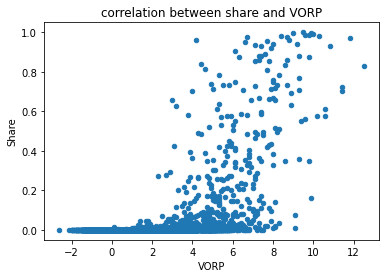

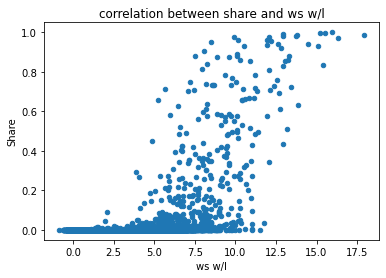

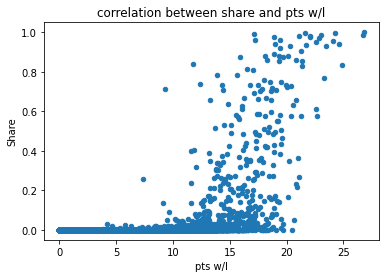

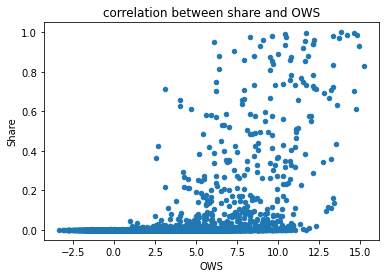

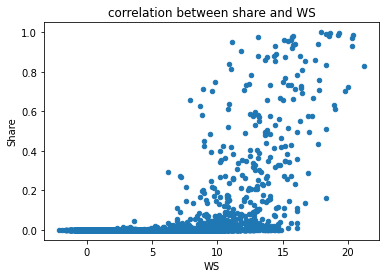

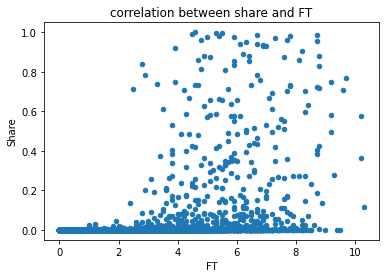

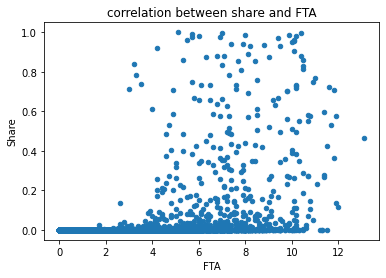

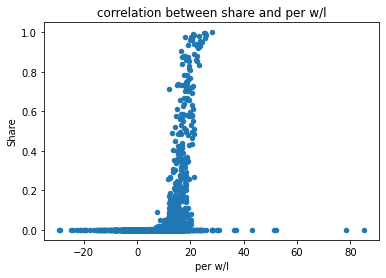

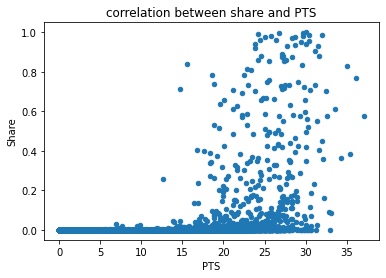

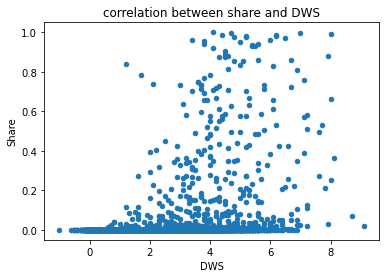

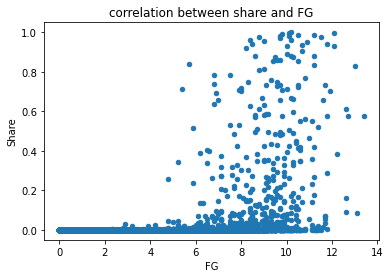

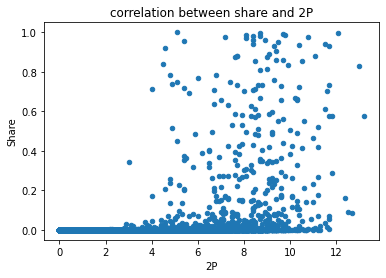

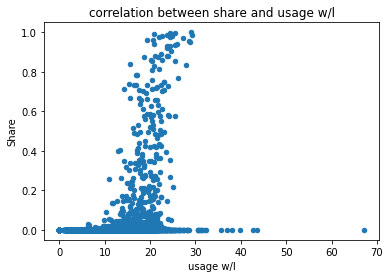

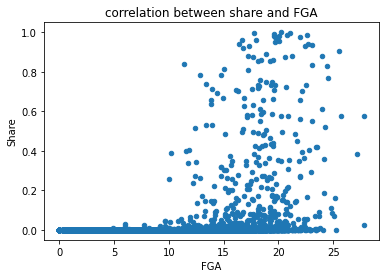

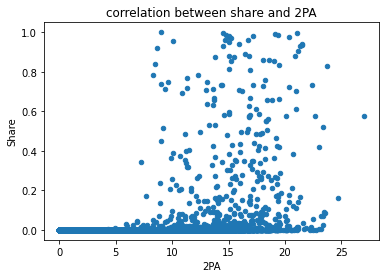

In [35]:
for col in correlated:
    full[[col, 'Share']].plot(kind = 'scatter', x = col, y = 'Share')

    plt.title(f"correlation between share and {col}")

Based on these graphs, it seems like there are typically two clear clusters of data: Players who receive a considerable share of the votes (where the relationship between the variables seems more clear), and those who only receieve a very small fraction of the votes.  
  
Let's take a look at the frontrunners to get a better idea of the correlations between variables within this group.

In [14]:
contenders = full[full['Share'] >= 0.2]

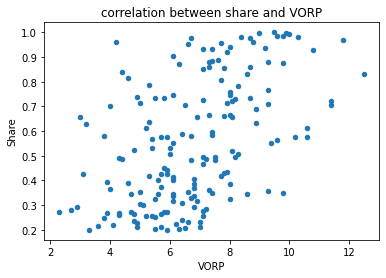

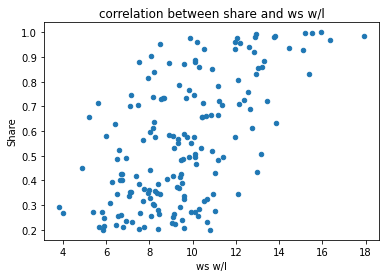

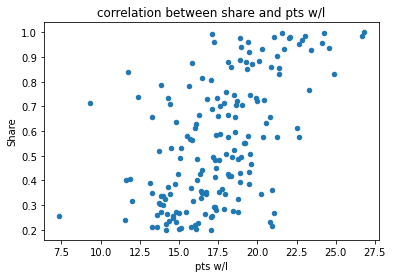

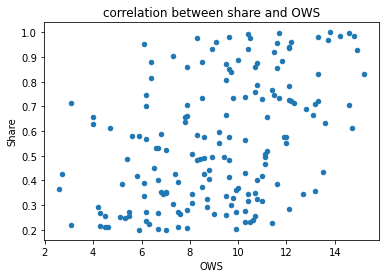

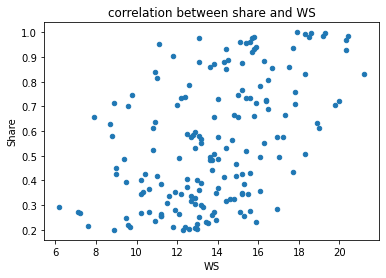

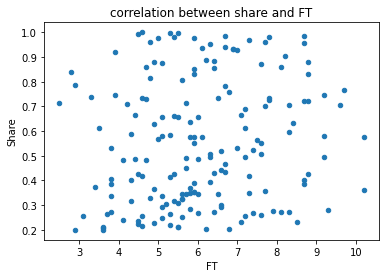

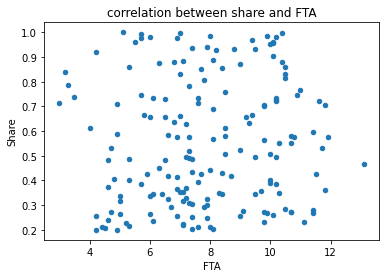

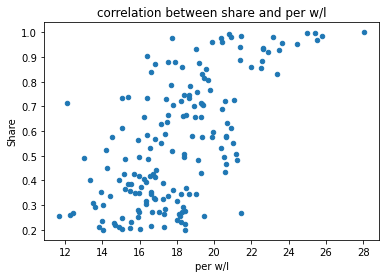

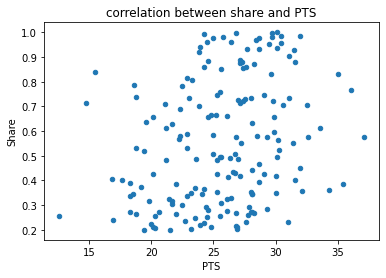

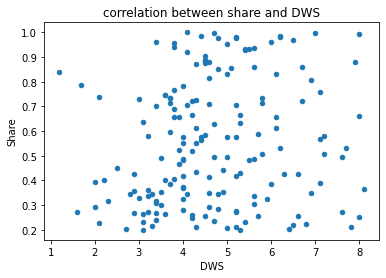

In [15]:
for col in correlated:
    contenders[[col, 'Share']].plot(kind = 'scatter', x = col, y = 'Share')

    plt.title(f"correlation between share and {col}")

Repeating our analysis of the correlation coefficients:

In [16]:
new_corrs = []
for col in correlated:
    correlation = contenders['Share'].corr(contenders[col])
    new_corrs.append((col, correlation))
new_corrs

[('VORP', 0.5100708704530156),
 ('ws w/l', 0.5897418421808763),
 ('pts w/l', 0.5522106164283088),
 ('OWS', 0.4398865508996197),
 ('WS', 0.4900557505691531),
 ('FT', 0.15257288093813207),
 ('FTA', 0.08272296234440733),
 ('per w/l', 0.6440408479560451),
 ('PTS', 0.28061633339569825),
 ('DWS', 0.14469220272870087)]

We see that these features have slightly weaker correlations with the vote share amongst top candidates, but ultimately should still be our best predictors.

### Prediction 

**Defining helpers**  
Now that we've identified our useful features, it's time to make our predictions.  
We'll start by defining some helper functions

In [17]:
def get_train(year, df):
    training = df[df['Year'] != year]
    x_train = training[correlated]
    y_train = training['Share']
    
    test = df[df['Year'] == year]
    x_test = test[correlated]
    y_test = test['Share']
    
    return x_train, y_train, x_test, y_test

In [18]:
def predict_share(year, df, pred):
    X_train, Y_train, X_test, Y_test = get_train(year, df)
    players = df['Player']
    
    pred.fit(X_train, Y_train)
    predictions = pred.predict(X_test)
    
    out = X_test.copy()
    out['Actual share'] = Y_test
    out['Predicted share'] = predictions
    out['Player'] = players
    return out[['Actual share', 'Predicted share', 'Player']]
    

In [19]:
def name_mvp(df):
    return df.sort_values(by = 'Predicted share', ascending = False)['Player'].iloc[0]

In [76]:
name_mvp(predict_share(2016, full, XGBRegressor(n_estimators=20, max_depth= 20, learning_rate = 0.5, subsample=1, 
                                    colsample_bytree=1)).sort_values(by = 'Predicted share'))

'Stephen Curry'

In [86]:
idk_test = [name_mvp(predict_share(year, full, XGBRegressor(n_estimators=20, max_depth= 20, learning_rate = 0.5, subsample=1, 
                                    colsample_bytree=1))) 
         for year in full.sort_values(by = 'Year')['Year'].unique()]

In [92]:
winners = full[full['Rank'] == '1'].reset_index().sort_values(by = 'Year')
final = winners[['Year', 'Player']].rename({'Player': 'Actual MVP'}, axis = 1)
final['Predicted MVP'] = idk_test
#final

In [91]:
final['Correct'] = final['Actual MVP'] == final['Predicted MVP']
final['Correct'].mean()

0.6744186046511628

In [28]:
def mvp_table(df, regressor):
    predicted_winners = [name_mvp(predict_share(year, df, regressor)) 
         for year in df.sort_values(by = 'Year')['Year'].unique()]
    
    winners = df[df['Rank'] == '1'].reset_index().sort_values(by = 'Year')
    final = winners[['Year', 'Player']].rename({'Player': 'Actual MVP'}, axis = 1)
    final['Predicted MVP'] = predicted_winners
    
    final['Correct'] = final['Actual MVP'] == final['Predicted MVP']
    return final

In [61]:
def pred_mse(df):
    return mean_squared_error(df['Actual share'], df['Predicted share'])

**Predictor**

After some experimentation, it seems that a gradient boosted decision tree regressor (using XGboost) with the following hyperparameters produces the best predictions.

In [104]:
xgb_result = mvp_table(full,
                       XGBRegressor(n_estimators=20, max_depth= 50, learning_rate = 0.5)
                      )
xgb_result

,Year,Actual MVP,Predicted MVP,Correct
31,1980,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,True
21,1981,Julius Erving,Julius Erving,True
10,1982,Moses Malone,Julius Erving,False
22,1983,Moses Malone,Larry Bird,False
37,1984,Larry Bird,Adrian Dantley,False
38,1985,Larry Bird,Larry Bird,True
27,1986,Larry Bird,Larry Bird,True
0,1987,Magic Johnson,Magic Johnson,True
32,1988,Michael Jordan,Larry Bird,False
1,1989,Magic Johnson,Magic Johnson,True


The model produces a fairly accurate prediction for the winner of each year's award (correct about 81% of the time).

In [105]:
xgb_result['Correct'].mean()

0.6744186046511628

However, the model does a pretty good job of predicting the actual vote share each candidate received. For example, let's take a look at the most recent year.

In [65]:
predicted_21 = predict_share(2021, full, XGBRegressor(n_estimators=20, max_depth= 30, learning_rate = 0.5, subsample=1, 
                                    colsample_bytree=1))
print(f'The mean squared error for 2021 is {pred_mse(predicted_21)}')
predicted_21.sort_values(by = 'Predicted share', ascending = False)

The mean squared error for 2021 is 0.0003286263409822962


,Actual share,Predicted share,Player
708,0.961,0.823247,Nikola Jokić
10476,0.580,0.413663,Joel Embiid
12088,0.345,0.267966,Giannis Antetokounmpo
4396,0.449,0.243813,Stephen Curry
14629,0.000,0.180575,Donovan Mitchell
...,...,...,...
9676,0.000,-0.000471,Karl-Anthony Towns
12094,0.000,-0.000811,Khris Middleton
7578,0.000,-0.001531,Jimmy Butler
1566,0.138,-0.001931,Chris Paul


We can examine the mean squared error for each year to see how this trend plays out over time.

In [68]:
years = [i for i in range(1980, 2022)]
mses = [pred_mse(predict_share(year, full, XGBRegressor(n_estimators=20, max_depth= 30, learning_rate = 0.5, subsample=1, 
                                    colsample_bytree=1))) for year in years]

In [69]:
pd.DataFrame({'Year': years, 'Mean Squared Error': mses}).set_index('Year')

,Mean Squared Error
Year,
1980,0.000716
1981,0.000725
1982,0.001875
1983,0.001877
1984,0.002671
1985,0.000795
1986,0.000939
1987,0.001146
1988,0.001940


We see that the MSE is consistently fairly low, implying that our model does a good job of predicting the average player's vote share. However, it is worth noting that this may be misleading, as the majority of the players in a season are not serious MVP contenders, and will have stats which reflect this.  